In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import seaborn as sns
from scipy import stats
import os
import re
import pickle
import imutils
from scipy.signal import find_peaks, savgol_filter
from pathlib import Path
import glob
from pathlib import Path
import pandas as pd

In [2]:
def init_condition(avis, x, y):
    capture = cv.VideoCapture(avis)
    _, frame1 = capture.read()
    
    # Crop to the selected 50x50 region
    frame1 = frame1[y:y+50, x:x+50]
    
    num_frames = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255  # Set saturation channel
    
    return capture, num_frames, hsv

In [3]:
def select_roi_interactive(avis):
    # Initialize video capture
    capture = cv.VideoCapture(avis)
    ret, frame = capture.read()
    if not ret:
        raise ValueError("Failed to read video")
    
    # Variables to store ROI coordinates
    roi_selected = False
    x_center, y_center = -1, -1

    # Mouse callback function
    def mouse_callback(event, x, y, flags, param):
        nonlocal roi_selected, x_center, y_center
        if event == cv.EVENT_LBUTTONDOWN:
            x_center, y_center = x, y
            roi_selected = True

    # Create window and set mouse callback
    cv.namedWindow("Select ROI Center")
    cv.setMouseCallback("Select ROI Center", mouse_callback)

    while True:
        display_frame = frame.copy()
        if roi_selected:
            # Ensure ROI stays within frame boundaries
            x = max(0, min(x_center - 25, frame.shape[1] - 50))
            y = max(0, min(y_center - 25, frame.shape[0] - 50))
            
            # Draw the 50x50 ROI rectangle
            cv.rectangle(display_frame, (x, y), (x+50, y+50), (0, 255, 0), 2)
            
            # Show cropped preview in a new window
            cropped_preview = frame[y:y+50, x:x+50]
            cv.imshow("Cropped Preview", cropped_preview)
        
        cv.imshow("Select ROI Center", display_frame)
        key = cv.waitKey(1) & 0xFF
        if key == ord('q') and roi_selected:  # Press 'q' to confirm
            break
        elif key == 27:  # Press ESC to exit
            cv.destroyAllWindows()
            capture.release()
            return None, None

    cv.destroyAllWindows()
    capture.release()
    
    # Final ROI coordinates (top-left corner)
    x = max(0, min(x_center - 25, frame.shape[1] - 50))
    y = max(0, min(y_center - 25, frame.shape[0] - 50))
    return x, y

In [5]:
fish_date = "20241017"
no = "F6"
set_no = 1

main_dir = f"G://2p_hsc//{fish_date}//hsa-sizetuning//{no}//"
excel_path = f"G://annotation//{fish_date}-{no}.xlsx"
h5_path = f"G://2p_hsc//{fish_date}//hsa-sizetuning//{no}//{no}-set00{set_no}-b-sweep-200-fps.h5"

avis = glob.glob(f"{main_dir}/**.mp4")
avis = [str(Path(avi).resolve()) for avi in avis]
avis

['G:\\2p_hsc\\20241017\\hsa-sizetuning\\F6\\F6-set001-b-sweep-200-fps.mp4',
 'G:\\2p_hsc\\20241017\\hsa-sizetuning\\F6\\F6-set002-r-spiral-200-fps.mp4',
 'G:\\2p_hsc\\20241017\\hsa-sizetuning\\F6\\F6-set003-l-spiral-200-fps.mp4',
 'G:\\2p_hsc\\20241017\\hsa-sizetuning\\F6\\F6-set004-b-spiral-200-fps.mp4']

In [8]:
avi = avis[0]
fish_id = fish_date + '-' + no

save_dir = f"G:/swim_motion_data/size_tunning/{fish_id}/set00{set_no}"
Path(save_dir).mkdir(parents=True, exist_ok = True)

In [9]:
x_cord, y_cord = select_roi_interactive(avi)
capture, num_frames, hsv = init_condition(avi, x_cord, y_cord)

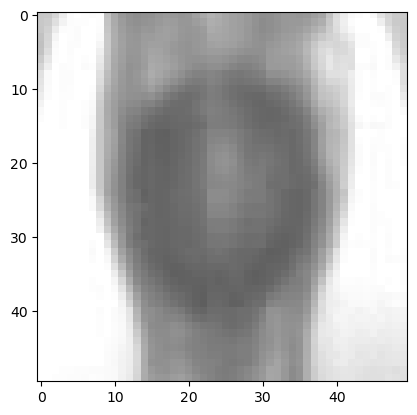

In [10]:
#preview the cropped video
capture.set(cv.CAP_PROP_POS_FRAMES, 1)

# Read and crop the first frame again
ret, frame = capture.read()
if ret:
    cropped_frame = frame[y_cord:y_cord+50, x_cord:x_cord+50]
    plt.imshow(cropped_frame)
    

## calcuate mean squared erro(mseval) and fit bimodel

In [11]:
from tqdm import tqdm
mseval = np.zeros(num_frames - 1)  # Preallocate array

ret, prev_frame = capture.read()
prev_frame = prev_frame[y_cord:y_cord+50, x_cord:x_cord+50]
prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY).astype(np.float32)

for i in tqdm(range(1, num_frames)):
    ret, curr_frame = capture.read()
    if not ret:
        break
        
    curr_frame = curr_frame[y_cord:y_cord+50, x_cord:x_cord+50]
    curr_gray = cv.cvtColor(curr_frame, cv.COLOR_BGR2GRAY).astype(np.float32)

    diff = curr_gray - prev_gray
    mse = np.mean(diff ** 2)
    mseval[i-1] = mse 
    
    prev_gray = curr_gray.copy()

100%|███████████████████████████████████████████████████████████████████████▉| 155997/155999 [01:06<00:00, 2337.28it/s]


### parameters

Text(0.5, 0, 'Frames')

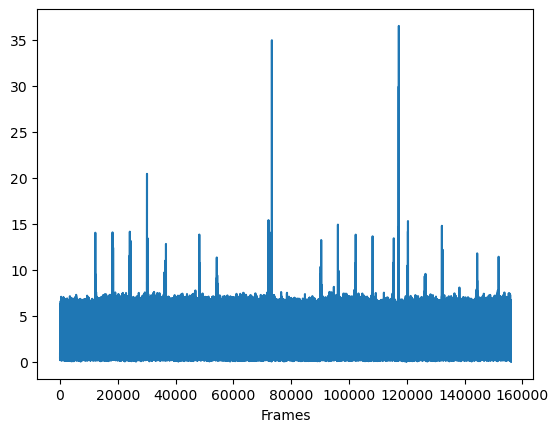

In [12]:
plt.plot(mseval)
plt.xlabel("Frames")

In [13]:
# import numpy as np
# from scipy.stats import gaussian_kde
# from scipy.signal import argrelmin

# # Compute KDE
# kde = gaussian_kde(mseval)
# x = np.linspace(np.min(mseval), np.max(mseval), 1000)  # Grid points
# y = kde(x)  # Density values

# from scipy.signal import find_peaks

# # Find peaks in the KDE
# peaks, _ = find_peaks(y)  # Adjust `prominence` as needed
# peak1, peak2 = x[peaks[0]], x[peaks[1]]  # Two largest peaks

# # Get the values between the two peaks and find the minimum
# valid_indices = [i for i in range(x.shape[0]) if i > peaks[0] and i < peaks[1]]
# minimum = x[valid_indices[np.argmin(y[valid_indices])]]

# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(4,3))
# sns.kdeplot(mseval, shade=True,color='crimson', label='KDE')

# # Plot peaks
# plt.scatter([peak1, peak2], kde([peak1, peak2]), color='blue', s=50, label='Peaks')

# # Plot inflection point
# plt.axvline(minimum, color='black', linestyle='--', 
#             label='Inflection')
# plt.xlim(0, 12)
# plt.title(f"Mean Squared Error")
# plt.legend()
# plt.show()

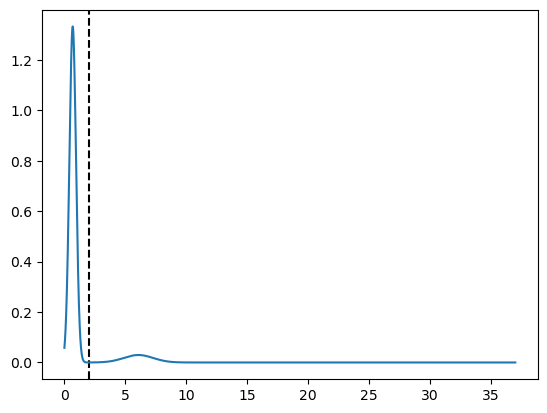

In [14]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 2)
mseval = np.array(mseval)
gmm.fit(mseval.reshape(-1, 1))

x = np.linspace(0, np.ceil(np.max(mseval)), 10000).reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

#### peak
peaks, _ = find_peaks(y)  # Adjust `prominence` as needed
peak1, peak2 = x[peaks[0]], x[peaks[1]]  # Two largest peaks

# Get the values between the two peaks and find the minimum
valid_indices = [i for i in range(x.shape[0]) if i > peaks[0] and i < peaks[1]]
minimum = x[valid_indices[np.argmin(y[valid_indices])]]

plt.axvline(minimum, color='black', linestyle='--', 
            label='Inflection')
plt.plot(x, y)

In [15]:
mse_threshold = minimum
res = []
for a in range(len(mseval)):
        if mseval[a] > mse_threshold:
            res.append(a)

In [16]:
len(res)

13806

In [17]:
def load_significant_frames(video_path, significant_indices):
    """Load frames that exceeded the MSE threshold"""
    cap = cv.VideoCapture(video_path)
    significant_frames = []
    
    for idx in tqdm(range(int(cap.get(cv.CAP_PROP_FRAME_COUNT)))):
        ret, frame = cap.read()
        if not ret:
            break
        frame = frame[y_cord:y_cord+50, x_cord:x_cord+50]
        if idx in significant_indices:
            significant_frames.append(frame)
    
    cap.release()
    return significant_frames

In [18]:
frames = load_significant_frames(avi, res)

100%|████████████████████████████████████████████████████████████████████████| 156000/156000 [01:58<00:00, 1321.45it/s]


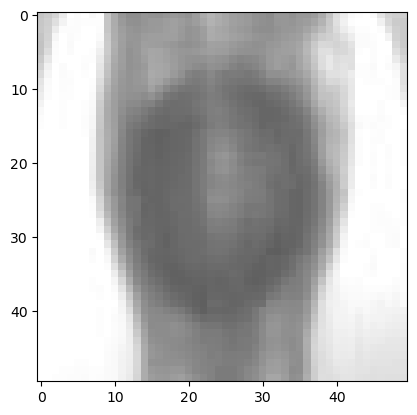

In [19]:
plt.imshow(frames[0])

# Optical Flow Analysis
   

In [20]:
vertical_motion = []
prev_gray = cv.cvtColor(frames[0], cv.COLOR_BGR2GRAY)

for frame in tqdm(frames[1:], desc="Analyzing Motion"):
    curr_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Calculate dense optical flow
    flow = cv.calcOpticalFlowFarneback(
        prev_gray, curr_gray, 
        None, 0.5, 3, 15, 3, 5, 1.2, 0
    )
    
    # Focus on vertical motion (y-axis component)
    vertical_flow = flow[..., 1]
    avg_vertical = np.mean(vertical_flow)
    vertical_motion.append(avg_vertical)
    
    prev_gray = curr_gray
vertical_motion = np.array(vertical_motion)

Analyzing Motion: 100%|████████████████████████████████████████████████████████| 13805/13805 [00:09<00:00, 1516.64it/s]


In [21]:
vertical_motion = -vertical_motion

In [22]:
# sns.kdeplot(vertical_motion, shade=True,color='crimson', label='KDE')

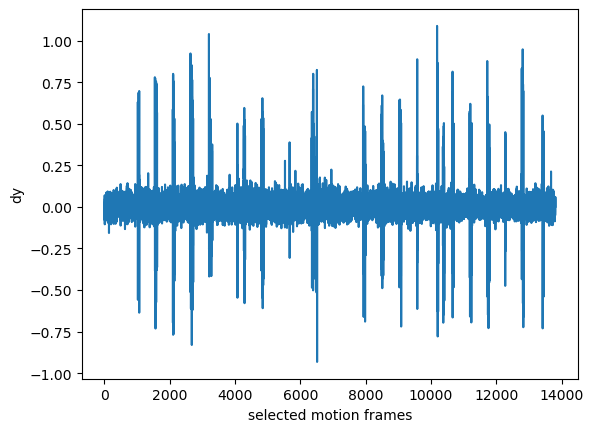

In [23]:
plt.plot(vertical_motion)
plt.ylabel("dy")
plt.xlabel("selected motion frames")

np.save(f"{save_dir}/y_shift.npy",vertical_motion)

# trimodel fitting

In [24]:
# from sklearn.mixture import GaussianMixture
# gmm = GaussianMixture(n_components = 3)
# gmm.fit(vertical_motion.reshape(-1, 1))

# x_1 = np.linspace(np.min(vertical_motion), np.ceil(np.max(vertical_motion)), 10000).reshape(-1, 1)
# y_2 = np.exp(gmm.score_samples(x_1))

# plt.plot(x_1, y_2)
# plt.title("attempt to fit tri-model")

In [25]:
def noise_detection(smoothed_signal, noise_window=10,
                             min_duration=3, prominence_factor=2.0):
    # 1. Estimate noise characteristics using rolling baseline
    noise_estimates = []
    for i in range(len(smoothed_signal)):
        start = max(0, i - noise_window)
        end = min(len(smoothed_signal), i + noise_window)
        noise_estimates.append(np.std(smoothed_signal[start:end]))
    
    noise_std = np.median(noise_estimates)  # Robust noise estimate
    return noise_std

In [26]:
noise_level = noise_detection(
    vertical_motion,
    noise_window=20,       # Larger for stable baselines
    min_duration=1,        # Minimum frames for valid peak
    prominence_factor=5  # Higher = fewer false positives
)

# Low Pass fliter

In [201]:
# b, a = signal.butter(5, 0.2, "low")

# X_k_smoothed = signal.filtfilt(b, a, vertical_motion) + noise_level * 3.5

# plt.plot(vertical_motion, label="X[k]", c="b")
# plt.plot(X_k_smoothed, label="Threshold", c="r", alpha=0.2)
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
# plt.title("X[k] with Dynamic Threshold")
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Magnitude (dB)")
# plt.show()

# CFAR detector

In [27]:
from scipy import signal
from numpy.lib.stride_tricks import sliding_window_view
def cfar_fast(
    x: np.ndarray,
    num_ref_cells: int,
    num_guard_cells: int,
    bias: float = 1,
    method=np.mean,
):
    pad = int((num_ref_cells + num_guard_cells))
    # fmt: off
    window_mean = np.pad(                                                                   # Pad front/back since n_windows < n_points
        method(                                                                             # Apply input method to remaining compute cells
            np.delete(                                                                      # Remove guard cells, CUT from computation
                sliding_window_view(x, (num_ref_cells * 2) + (num_guard_cells * 2)),        # Windows of x including CUT, guard cells, and compute cells
                np.arange(int(num_ref_cells), num_ref_cells + (num_guard_cells * 2) + 1),   # Get indices of guard cells, CUT
                axis=1),
            axis=1
        ), (pad - 1, pad),
        constant_values=(np.nan, np.nan)                                                    # Fill with NaNs
    ) + bias                                                                             
    # fmt: on
    return window_mean

<Figure size 640x480 with 0 Axes>

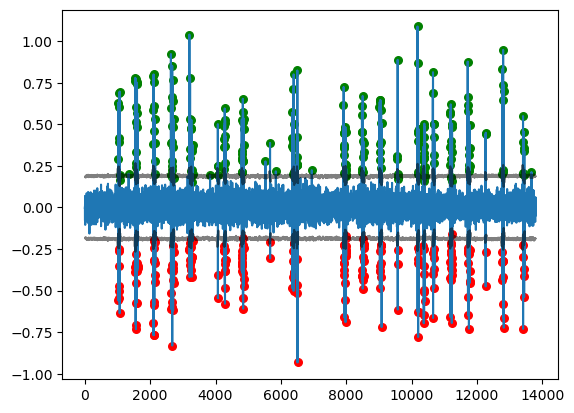

In [40]:
# %matplotlib widget
#4.1
factor = 4.1
threshold = cfar_fast(vertical_motion, num_guard_cells=1, num_ref_cells=15, bias=noise_level * factor)
up_peak_idxs = []
down_peak_idxs = []
for i, dy in enumerate(vertical_motion):
    if dy > threshold[i]:
        up_peak_idxs.append(i)
    if dy < -threshold[i]:
        down_peak_idxs.append(i)
        
fig = plt.figure()
fig, ax = plt.subplots(1)
ax.plot(vertical_motion)
ax.plot(abs(threshold), c="black", alpha=0.5)
ax.plot(-abs(threshold), c="black", alpha=0.5)
# Plot peaks
ax.scatter(up_peak_idxs, vertical_motion[up_peak_idxs], c='green', s=30, label='Valid Up')
ax.scatter(down_peak_idxs, vertical_motion[down_peak_idxs], c='red', s=30, label='Valid Down')

# plt.

In [338]:
# def detect_significant_motion(smoothed_signal, noise_window=10,
#                              min_duration=3, prominence_factor=2.0):
#     # 1. Estimate noise characteristics using rolling baseline
#     noise_estimates = []
#     for i in range(len(smoothed_signal)):
#         start = max(0, i - noise_window)
#         end = min(len(smoothed_signal), i + noise_window)
#         noise_estimates.append(np.std(smoothed_signal[start:end]))
    
#     noise_std = np.median(noise_estimates)  # Robust noise estimate
    
#     # 2. Adaptive threshold based on noise floor
#     upward_thresh = prominence_factor * noise_std
#     downward_thresh = -prominence_factor * noise_std

#     upwards = []
#     downwards = []
#     for i, dy in enumerate(vertical_motion):
#         if dy > upward_thresh:
#             upwards.append(i)
#         if dy < downward_thresh:
#             downwards.append(i)
    
#     return upwards, downwards, noise_std

In [343]:
# prominence_factor = 5
# up_peaks, down_peaks, noise_level = detect_significant_motion(
#     vertical_motion,
#     noise_window=20,       # Larger for stable baselines
#     min_duration=1,        # Minimum frames for valid peak
#     prominence_factor=prominence_factor  # Higher = fewer false positives
# )

In [39]:
# def plot_results(smoothed, up_peaks, down_peaks, noise_std, prominence_factor):
#     # plt.figure(figsize=(12,6))
#     plt.plot(smoothed, label='Vertical Motion')
    
#     # Plot thresholds
#     plt.axhline(-prominence_factor*noise_std, c='r', ls='--', alpha=0.5, label='Upward Threshold')
#     plt.axhline(prominence_factor*noise_std, c='g', ls='--', alpha=0.5, label='Downward Threshold')
    
#     # Plot peaks
#     plt.scatter(up_peaks, smoothed[up_peaks], c='green', s=30, label='Valid Up')
#     plt.scatter(down_peaks, smoothed[down_peaks], c='red', s=30, label='Valid Down')
    
    
#     plt.xlabel("Frames")
#     plt.ylabel("Vertical Motion")
#     # plt.legend()
#     plt.xlim(6350, 6500)
#     plt.show()

# plot_results(vertical_motion, up_peaks, down_peaks, noise_level, prominence_factor)

# map the frame back

In [41]:
len(res[:-1])

13805

In [42]:
num_frames

156000

In [43]:
len(vertical_motion)

13805

In [44]:
y_motions = np.zeros(num_frames)

ori_up_idxs = []
ori_down_idxs = []
for i, re in enumerate(res[:-1]):
    y_motions[re] = vertical_motion[i]
for i in up_peak_idxs:
    ori_up_idxs.append(res[i])
for j in down_peak_idxs:
    ori_down_idxs.append(res[j])

In [45]:
len(y_motions)

156000

In [46]:
df_up = pd.DataFrame(
    {
        "res": up_peak_idxs,
        "ori": ori_up_idxs
    }
)
df_up

,res,ori
0,1022,12217
1,1023,12218
2,1029,12230
3,1045,12337
4,1046,12339
...,...,...
243,13441,151744
244,13442,151745
245,13443,151746
246,13452,151767


In [47]:
df_down = pd.DataFrame(
    {
        "res": down_peak_idxs,
        "ori": ori_down_idxs
    }
)
df_down

,res,ori
0,1024,12219
1,1033,12234
2,1034,12237
3,1047,12345
4,1054,12370
...,...,...
223,13416,151473
224,13417,151485
225,13447,151751
226,13448,151755


In [54]:
ori_up_idxs[:11]

[12217, 12218, 12230, 12337, 12339, 12365, 12429, 12449, 12477, 15729, 18138]

In [51]:
ori_down_idxs[:9]

[12219, 12234, 12237, 12345, 12370, 12375, 12381, 12453, 18142]

# Episode

In [55]:
def find_periods(ori_up_idx, ori_down_idx):
    ori_up = sorted(ori_up_idx)
    ori_down = sorted(ori_down_idx)
    used_up = set()
    used_down = set()
    periods = []
    i_up = 0

    while i_up < len(ori_up):
        current_up = ori_up[i_up]
        if current_up in used_up:
            i_up += 1
            continue

        # Expand up chain
        up_chain = [current_up]
        used_up.add(current_up)
        j_up = i_up + 1
        while j_up < len(ori_up):
            next_up = ori_up[j_up]
            if next_up - current_up > 40:
                break
            # Check if any down exists between current_up and next_up
            has_down = False
            for d in ori_down:
                if current_up < d < next_up and d not in used_down:
                    has_down = True
                    break
            if has_down:
                break
            up_chain.append(next_up)
            used_up.add(next_up)
            current_up = next_up
            j_up += 1

        # Find down chain
        down_chain = []
        current_down = None
        # Find the first down after current_up and within 40 frames
        for d in ori_down:
            if d > current_up and d <= current_up + 40 and d not in used_down:
                current_down = d
                break
        if current_down is None:
            i_up += 1
            continue

        down_chain.append(current_down)
        used_down.add(current_down)
        # Expand down chain
        while True:
            next_down = None
            for d in ori_down:
                if d > current_down and d <= current_down + 40 and d not in used_down:
                    next_down = d
                    break
            if next_down is None:
                break
            # Check if any up exists between current_down and next_down
            has_up = False
            for u in ori_up:
                if current_down < u < next_down and u not in used_up:
                    has_up = True
                    break
            if has_up:
                break
            down_chain.append(next_down)
            used_down.add(next_down)
            current_down = next_down

        periods.append([up_chain[0], down_chain[-1]])

        # Move i_up to the next unused up index
        while i_up < len(ori_up) and ori_up[i_up] in used_up:
            i_up += 1

    return periods

In [57]:
episodes = find_periods(ori_up_idxs, ori_down_idxs)

In [58]:
episodes

[[12217, 12219],
 [12230, 12237],
 [12337, 12345],
 [12365, 12381],
 [12429, 12453],
 [18138, 18144],
 [18150, 18155],
 [18166, 18170],
 [18187, 18191],
 [18206, 18213],
 [18221, 18230],
 [18243, 18249],
 [18369, 18376],
 [18383, 18393],
 [18409, 18417],
 [24129, 24133],
 [24141, 24144],
 [24154, 24165],
 [24196, 24201],
 [24219, 24237],
 [24246, 24261],
 [24390, 24395],
 [24405, 24409],
 [24419, 24441],
 [30095, 30098],
 [30105, 30110],
 [30115, 30121],
 [30181, 30189],
 [30203, 30213],
 [30223, 30229],
 [30244, 30249],
 [30297, 30309],
 [30341, 30345],
 [30360, 30369],
 [30379, 30385],
 [30396, 30409],
 [30419, 30429],
 [36088, 36096],
 [36100, 36105],
 [36115, 36125],
 [36135, 36147],
 [36344, 36352],
 [36358, 36364],
 [36371, 36384],
 [36416, 36429],
 [36441, 36453],
 [36641, 36660],
 [45801, 45885],
 [48136, 48146],
 [48151, 48159],
 [48169, 48177],
 [48190, 48194],
 [48209, 48249],
 [48263, 48285],
 [54158, 54165],
 [54172, 54180],
 [54186, 54192],
 [54218, 54225],
 [54235, 54249

# plot eye angle shadow with motion

In [59]:
import pandas as pd

In [60]:
def get_behavior_timestamps(filename):
    t = np.loadtxt(filename)[:, 1]
    t = (t - t[0]) / 3515839
    return t


def get_tail_angles(df_tail, heading):
    xy = df_tail.values[:, ::2] + df_tail.values[:, 1::2] * 1j
    midline = -np.exp(1j * np.deg2rad(np.asarray(heading)))
    return -np.angle(np.diff(xy, axis=1) / midline[:, None])

In [61]:
def low_pass_filt(x, fs, cutoff, axis=0, order=2):
    from scipy.signal import butter, filtfilt

    b, a = butter(order, cutoff / (fs / 2), btype="low")
    return filtfilt(b, a, x, axis=axis)

In [62]:
def load_data(h5_path, fs=200):
    from scipy.interpolate import interp1d

    t = get_behavior_timestamps(Path(h5_path).with_suffix(".txt"))
    df_eye = pd.read_hdf(h5_path, "eye")
    eye_angles = df_eye[[("left_eye", "angle"), ("right_eye", "angle")]].values
    t_new = np.arange(int(t[-1]) * fs) / fs
    eye_angles = interp1d(t, eye_angles, axis=0, kind="cubic")(t_new)
    df_tail = pd.read_hdf(h5_path, "tail")
    tail_angles = get_tail_angles(df_tail, df_eye["heading"].values)
    tail_angles = interp1d(t, tail_angles, axis=0, kind="cubic")(t_new)

    return t_new, eye_angles, tail_angles


In [63]:

fs = 200  # target sampling frequency
t, eye_angles, tail_angles = load_data(h5_path, fs)

# conv_params = {
#     "hw": 100,  # half-width of the step function
#     "thr": 0.6,  # threshold for peak height
#     "dist": 80,  # distance between events
# }
eye_angles_filt = low_pass_filt(eye_angles, fs, 2)

In [64]:

ex = pd.read_excel(excel_path, usecols = [1,2,3], header = 1).drop(np.append(np.arange(25,49,1), 0)).reset_index().drop(["index"], axis=1)
is_pc = ex['is_pc'].values
is_strike = ex['is_strike'].values
pc_only = is_pc - is_strike
strike_only = is_strike
pc_only = np.nan_to_num(pc_only)
strike_only = np.nan_to_num(strike_only)
pc_accepted = pc_only.astype(bool)
strike_accepted = strike_only.astype(bool)

df_trial = pd.DataFrame({
    "trial" : ex["size"].values,
    "t_start" : np.arange(24) * 30 + 30,
    "t_end" : np.arange(24) * 30 + 32
})

In [65]:
df_trial["t_start"] = df_trial["t_start"]*200
df_trial["t_end"] = df_trial["t_end"]*200
df_trial

,trial,t_start,t_end
0,2.0,6000,6400
1,4.0,12000,12400
2,6.0,18000,18400
3,10.0,24000,24400
4,15.0,30000,30400
5,20.0,36000,36400
6,2.0,42000,42400
7,4.0,48000,48400
8,6.0,54000,54400
9,10.0,60000,60400


In [66]:
bout_params = {
    "n_angles_avg": 5,  # number of angles to average for tail tip angle
    "sigma": 4,  # sigma for gaussian filter
    "high": 10,  # high threshold for tail vigor
    "low": 5,  # low threshold for tail vigor
}
mean_tip_angle = tail_angles[..., -bout_params["n_angles_avg"] :].mean(-1)

Text(0.5, 0.95, '20241017-F6-set001-factor:4.1')

<Figure size 640x480 with 0 Axes>

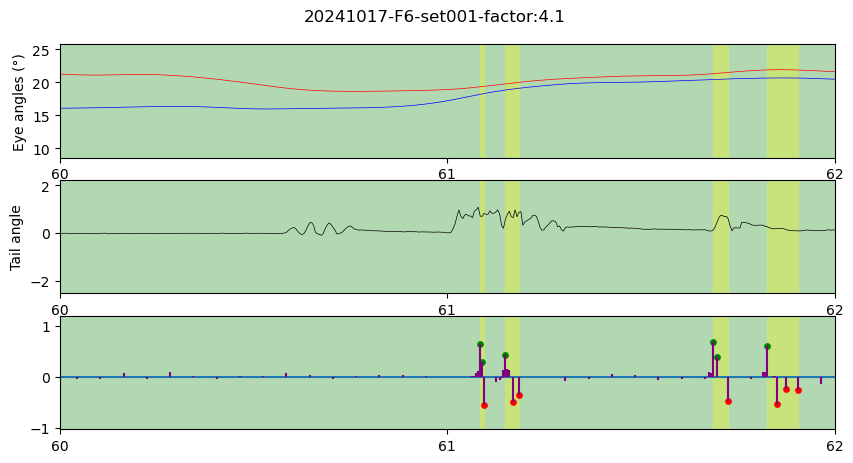

In [75]:
# %matplotlib inline

seconds = np.arange(0, 780,1)
tick_locations = np.arange(0, 780,1)*200

fig = plt.figure()
fig, axes = plt.subplots(3,1, figsize=(10,5)) # 100 8

ax1 = axes[0]
ax1.set_ylabel("Eye angles (°)")
ax1.plot(eye_angles_filt[:, 0], color="b", lw=0.5)
ax1.plot(eye_angles_filt[:, 1], color="r", lw=0.5)
# Set ticks and labels
ax1.set_xticks(tick_locations)
ax1.set_xticklabels([f"{s}" for s in seconds])


ax2 = axes[1]
ax2.set_ylabel("Tail angle")
ax2.plot(mean_tip_angle, color="black", lw=0.5)
# Set ticks and labels
ax2.set_xticks(tick_locations)
ax2.set_xticklabels([f"{s}" for s in seconds])

ax3 = axes[2]
ax3.plot(np.zeros(len(y_motions)))
ax3.stem(np.arange(len(y_motions)), y_motions, linefmt='purple', markerfmt=' ', basefmt=' ')
ax3.scatter(ori_up_idxs, y_motions[ori_up_idxs], c='green', s=15, label='Valid Up')
ax3.scatter(ori_down_idxs, y_motions[ori_down_idxs], c='red', s=15, label='Valid Down')
# Set ticks and labels
ax3.set_xticks(tick_locations)
ax3.set_xticklabels([f"{s}" for s in seconds])


for ax in axes:
    for j in range(len(df_trial)):
        if is_pc[j] == 0:
            ax.axvspan(df_trial["t_start"][j], df_trial["t_end"][j], color='grey', alpha=0.3, lw=0.5, zorder=-100)
        elif pc_only[j] == 1:
            ax.axvspan(df_trial["t_start"][j], df_trial["t_end"][j], color='red', alpha=0.3, lw=0, zorder=-100)
        if strike_only[j] == 1:
            ax.axvspan(df_trial["t_start"][j], df_trial["t_end"][j], color='green', alpha=0.3, lw=0, zorder=-100)

for ax in axes:
    for episode in episodes:
        ax.axvspan(episode[0], episode[-1], color='yellow', alpha=0.3, lw=0.5, zorder=-100)
    ax.set_xlim(60*200, 62*200)


title = f"{fish_id}-set00{set_no}-factor:{factor}"
plt.suptitle(title, y=0.95)

# plt.savefig(f"{save_dir}/episode_behaviour.png", transparent=None,
#         facecolor='white', dpi = 500
#        )

# Save thirdline Data into csv

In [221]:
df_up["ysft"] = y_motions[df_up["ori"].values]
df_down["ysft"] = y_motions[df_down["ori"].values]

df_up["is_up"] = [1] * len(df_up)
df_down["is_up"] = [-1] * len(df_down)

In [222]:
pd.concat([df_up, df_down], axis=1).to_csv(f'{save_dir}/motion_f:{factor}.csv', index=False)
combined_df = pd.concat([df_up, df_down], ignore_index=True)
combined_df.to_csv(f'{save_dir}/y_shift_idx.csv', index=False)

,res,ori,ysft,is_up
0,1023,12217,0.617648,1
1,1024,12218,0.286093,1
2,1030,12230,0.403434,1
3,1046,12337,0.672510,1
4,1047,12339,0.372129,1
...,...,...,...,...
470,13450,151473,-0.285060,-1
471,13451,151485,-0.225796,-1
472,13481,151751,-0.539023,-1
473,13482,151755,-0.361302,-1


In [223]:
combined_df.sort_values(by="ori").reset_index()

,index,res,ori,ysft,is_up
0,0,1023,12217,0.617648,1
1,1,1024,12218,0.286093,1
2,250,1025,12219,-0.560890,-1
3,2,1030,12230,0.403434,1
4,251,1034,12234,-0.502497,-1
...,...,...,...,...,...
470,472,13481,151751,-0.539023,-1
471,473,13482,151755,-0.361302,-1
472,248,13486,151767,0.320968,1
473,474,13487,151773,-0.389226,-1


# save fig of grouped-motions

In [224]:
def group_elements(combined_df, max_distance=200):
    sort_df = combined_df.sort_values(by="ori").reset_index()
    ori = sort_df["ori"].values
    res = sort_df["res"].values
    is_up = sort_df["is_up"].values
    
    groups = []
    current_ori_group = [ori[0]]  
    current_res_group = [res[0]]
    current_is_up_group = [is_up[0]]

    for i in range(1, len(ori)):
        if ori[i] - current_ori_group[-1] <= max_distance:
            current_ori_group.append(ori[i])
            current_res_group.append(res[i])
            current_is_up_group.append(is_up[i])
            
        else:
            df_group  = pd.DataFrame(
                {
                    "res" : current_res_group,
                    "ori" : current_ori_group,
                    "is_up": current_is_up_group
                }
            )
            
            groups.append(df_group)
            current_ori_group = [ori[i]]
            current_res_group = [res[i]]
            current_is_up_group = [is_up[i]]
    
    df_group  = pd.DataFrame(
                {
                    "res" : current_res_group,
                    "ori" : current_ori_group,
                    "is_up": current_is_up_group
                }
            )
            
    groups.append(df_group)
    
    return groups

In [225]:
grouped_array = group_elements(combined_df, max_distance=200)

In [226]:
len(grouped_array)

29

In [227]:
grouped_array[0]

,res,ori,is_up
0,1023,12217,1
1,1024,12218,1
2,1025,12219,-1
3,1030,12230,1
4,1034,12234,-1
5,1035,12237,-1
6,1046,12337,1
7,1047,12339,1
8,1048,12345,-1
9,1052,12365,1


In [233]:
qwert = 1.3
f"{qwert:0.0f}"

'1'

In [235]:
%matplotlib inline

episode_dir = f"{save_dir}/episode_f_{factor:0.0f}/"
Path(episode_dir).mkdir(parents=True, exist_ok=True)


for index, group in enumerate(grouped_array):
    fig = plt.figure()
    fig, axes = plt.subplots(3,1)
    
    ax1 = axes[0]
    ax1.set_ylabel("Eye angles (°)")
    ax1.plot(eye_angles_filt[:, 0], color="b", lw=0.5)
    ax1.plot(eye_angles_filt[:, 1], color="r", lw=0.5)

    
    ax2 = axes[1]
    ax2.set_ylabel("Tail angle")
    ax2.plot(mean_tip_angle, color="black", lw=0.5)

    
    ax3 = axes[2]
    ax3.plot(np.zeros(len(y_motions)))
    ax3.stem(np.arange(len(y_motions)), y_motions, linefmt='purple', markerfmt=' ', basefmt=' ')
    ax3.scatter(ori_up_idxs, y_motions[ori_up_idxs], c='green', s=15, label='Valid Up')
    ax3.scatter(ori_down_idxs, y_motions[ori_down_idxs], c='red', s=15, label='Valid Down')

    
    for ax in axes:
        for j in range(len(df_trial)):
            if is_pc[j] == 0:
                ax.axvspan(df_trial["t_start"][j], df_trial["t_end"][j], color='grey', alpha=0.3, lw=0.5, zorder=-100)
            elif pc_only[j] == 1:
                ax.axvspan(df_trial["t_start"][j], df_trial["t_end"][j], color='red', alpha=0.3, lw=0, zorder=-100)
            if strike_only[j] == 1:
                ax.axvspan(df_trial["t_start"][j], df_trial["t_end"][j], color='green', alpha=0.3, lw=0, zorder=-100)
                
        a = group["ori"].values[0]-100
        b = group["ori"].values[-1]+100
        ax.set_xlim(a, b)
        ax.set_xticks((np.arange(a/200, b/200, 0.5)*200).astype(int) )
        ax.set_xticklabels([f"{s:0.2f}" for s in np.arange(a/200, b/200, 0.5)])
    title = f"{group["res"].values[0]}-{group["res"].values[-1]}"
    plt.suptitle(title)
    plt.savefig(f"{episode_dir}/episode{index+1}.png", transparent=None,facecolor='white', dpi = 500)
    
    plt.close()

C:\Users\richa\AppData\Local\Temp\ipykernel_13424\4159874354.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(3,1)
C:\Users\richa\AppData\Local\Temp\ipykernel_13424\4159874354.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# output clips

In [237]:
total_frames = num_frames
group = grouped_array[3]
ori = group["ori"].values
res = group["res"].values

group_start = max(0, ori[0] - 100)
group_end = min(total_frames - 1, ori[-1] + 100)

In [238]:
group_start

np.int64(24029)

In [239]:
group_end

np.int64(24541)

In [241]:
%%capture

import cv2
import numpy as np
import os

def create_clips(video_path, grouped_array, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Process each group
    for i, group in enumerate(grouped_array):
        # Calculate start and end frames with buffer
        ori = group["ori"].values
        res = group["res"].values
        is_up = group["is_up"].values
        
        group_start = max(0, ori[0] - 100)
        group_end = min(total_frames - 1, ori[-1] + 100)
        
        
        # Calculate original group bounds for text display
        original_start = ori[0]
        original_end = ori[-1]
        
        # Set up video writer with 0.5x speed (double the duration)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        output_path = os.path.join(output_folder, f'clip_{i+1}.mp4')
        out = cv2.VideoWriter(output_path, fourcc, fps * 0.2, (width, height))
        
        # Set text properties
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_thickness = 3
        text_color = (255, 255, 255)  # White
        text_position = (45, 50)  # Top-Left corner
        
        # Seek to start frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, group_start)
        
        # Process frames in this group
        for frame_num in range(group_start, group_end + 1):
            ret, frame = cap.read()
            if not ret:
                break
                
            # Add "episode" text if within original group bounds
            if frame_num in ori:
                if (is_up[ori == frame_num][0] > 0):
                    cv2.putText(frame, 'up', text_position, 
                               font, font_scale, (255,0,0), font_thickness)
                elif (is_up[ori == frame_num][0] < 1):
                    cv2.putText(frame, 'down', text_position, 
                               font, font_scale, (0,0,255), font_thickness)
                
            
            # Write frame to output video
            out.write(frame)
        
        # Release current video writer
        out.release()
        print(f'Created clip {i+1} ({group_start}-{group_end} frames)')
    
    # Release video capture
    cap.release()
    print("All clips created successfully!")



In [242]:
video_path = avi
output_folder = f"{save_dir}/episode_video_f_{factor:0.0f}/"

create_clips(video_path, grouped_array, output_folder)

Created clip 1 (12117-12577 frames)
Created clip 2 (15629-15829 frames)
Created clip 3 (18038-18517 frames)
Created clip 4 (24029-24541 frames)
Created clip 5 (29995-30678 frames)
Created clip 6 (35988-36760 frames)
Created clip 7 (45701-45985 frames)
Created clip 8 (48036-48385 frames)
Created clip 9 (54058-54509 frames)
Created clip 10 (62213-62413 frames)
Created clip 11 (63893-64117 frames)
Created clip 12 (66017-66217 frames)
Created clip 13 (72005-72517 frames)
Created clip 14 (73176-73408 frames)
Created clip 15 (78437-78637 frames)
Created clip 16 (90034-90565 frames)
Created clip 17 (96044-96541 frames)
Created clip 18 (102003-102445 frames)
Created clip 19 (108023-108445 frames)
Created clip 20 (115246-115657 frames)
Created clip 21 (117099-117351 frames)
Created clip 22 (120069-120517 frames)
Created clip 23 (126058-126565 frames)
Created clip 24 (131991-132505 frames)
Created clip 25 (138059-138289 frames)
Created clip 26 (144046-144493 frames)
Created clip 27 (151313-15158